In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

# Load data
df = pd.read_csv("../raw_data/clensed_reviews.csv")

# Convert timestamp
df['time'] = pd.to_datetime(df['time'], unit='s')

# Check for missing data
missing_data = df.isnull().sum()

# Descriptive statistics
ratings_distribution = df['rating'].value_counts()


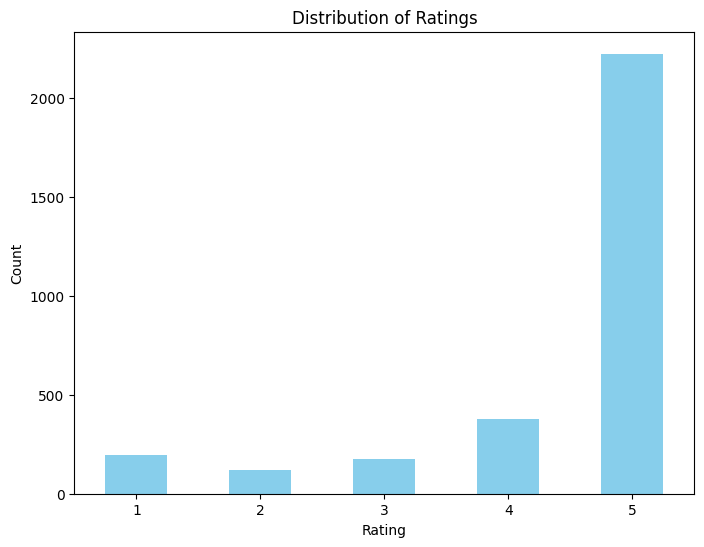

In [14]:
# Plot ratings distribution
plt.figure(figsize=(8, 6))
ratings_distribution.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

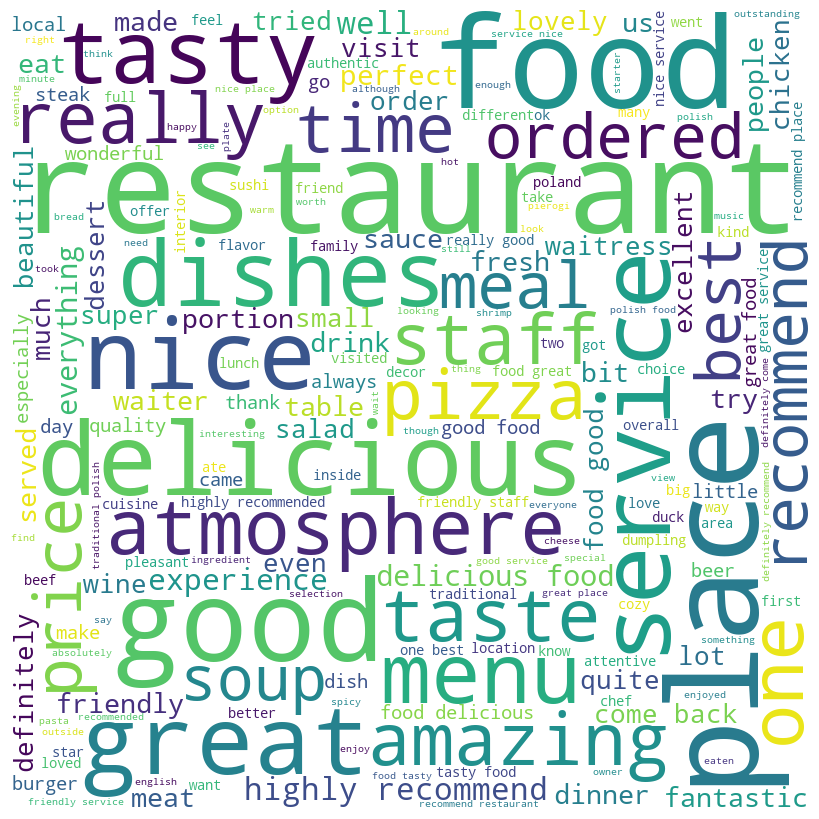

In [15]:
# Generate word cloud
def word_cloud_plot(df, sentiment_col, sentiment_value):
    comment_words = ' '
    stopwords = set(STOPWORDS)
    filtered_reviews = df[df[sentiment_col] == sentiment_value]['text'].dropna()

    for review in filtered_reviews:
        tokens = str(review).lower().split()
        comment_words += ' '.join(tokens) + ' '

    wordcloud = WordCloud(width=800, height=800, 
                          background_color='white', 
                          stopwords=stopwords, 
                          min_font_size=10).generate(comment_words)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Example: Generate word cloud for positive food reviews
word_cloud_plot(df, 'food', 'Positive')

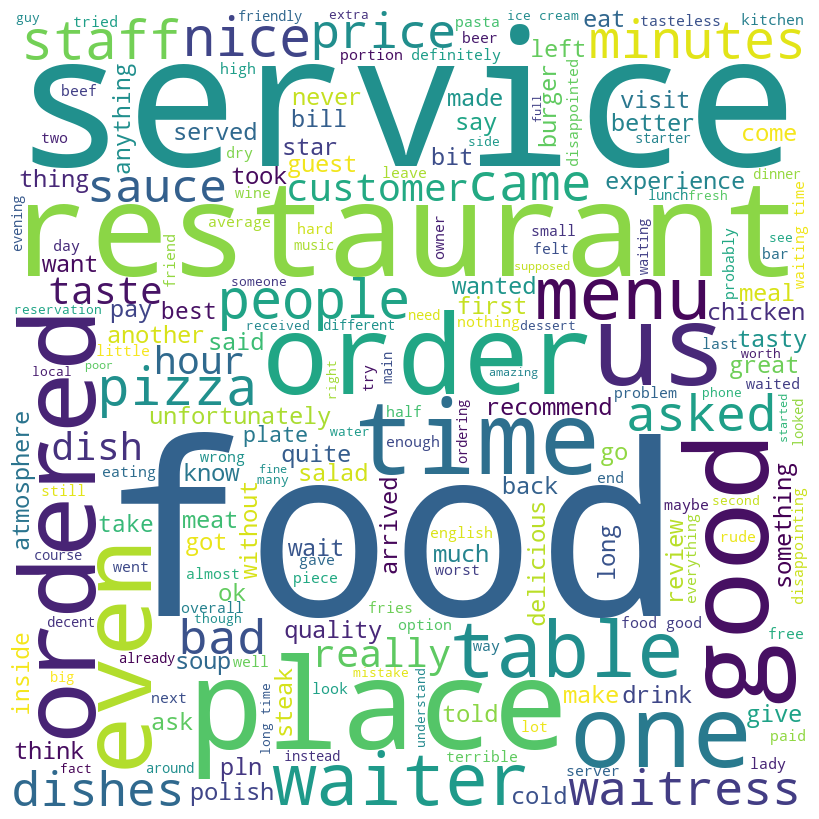

In [5]:
word_cloud_plot(df, 'service', 'Negative')

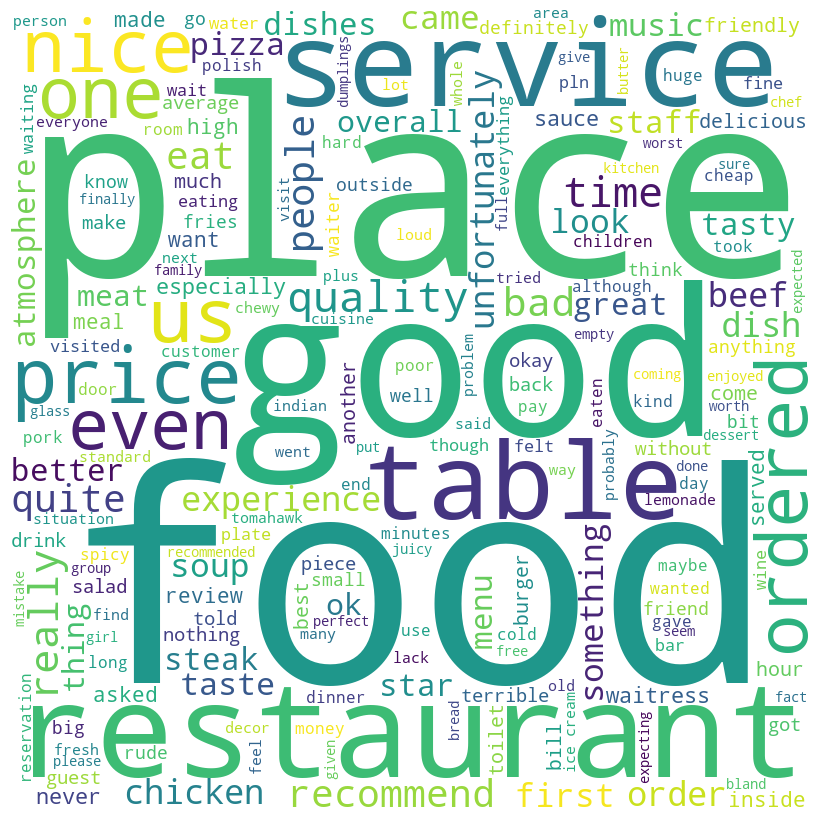

In [7]:
word_cloud_plot(df, 'atmosphere', 'Negative')

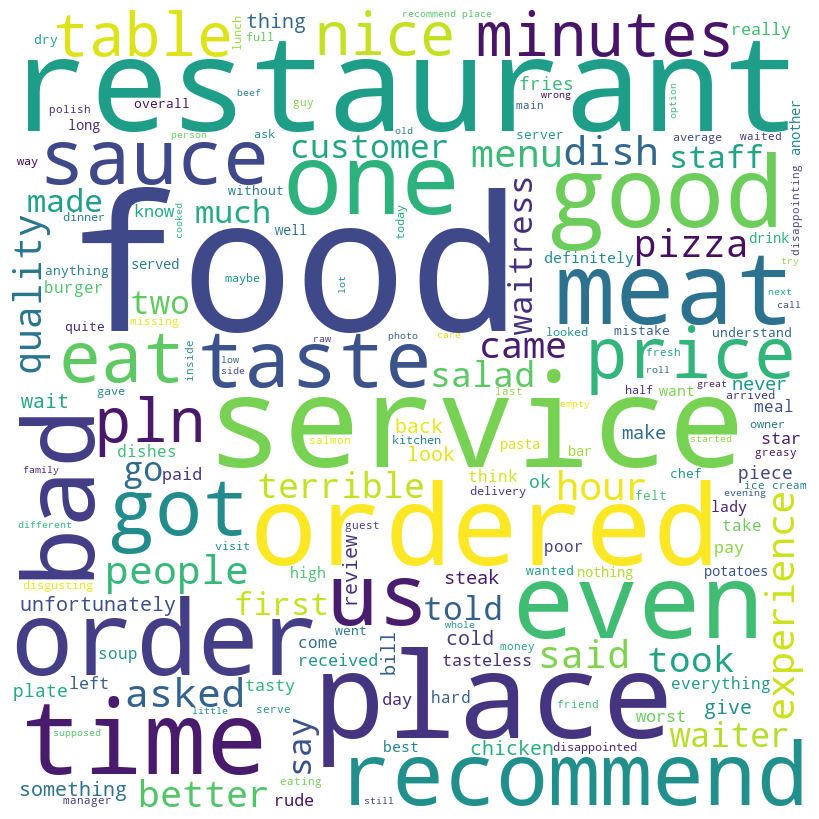

In [3]:
# word cloud for reviews with one star
word_cloud_plot(df, 'rating', 1)

Top 10 terms by TF-IDF scores:
food          433.082516
good          320.210588
place         301.077081
service       293.676573
nice          261.255955
great         259.759207
restaurant    248.820316
delicious     243.460317
recommend     226.504333
tasty         185.603671
dtype: float64


/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_5794/1051511385.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')


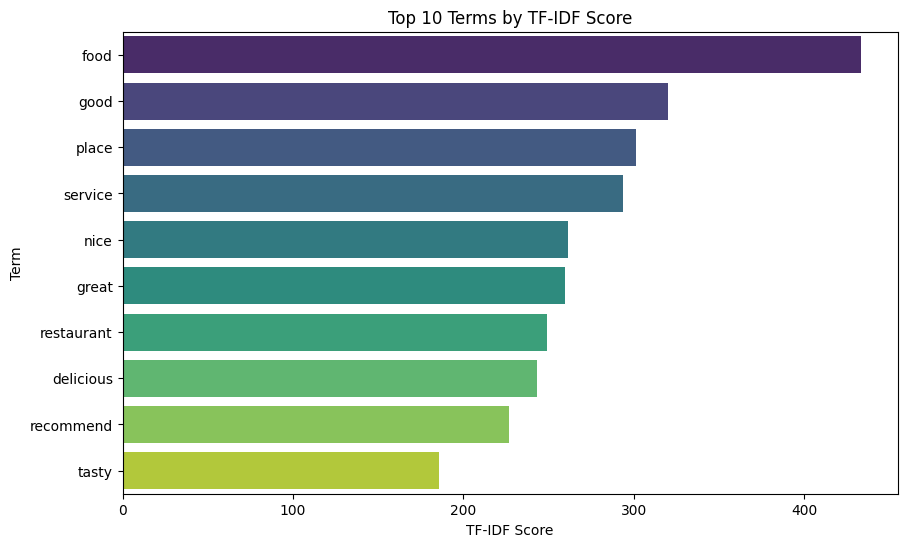

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../raw_data/clensed_reviews.csv")

# Preprocess text
def preprocess_text(text):
    # Remove punctuation, convert to lowercase
    return " ".join(word.lower() for word in str(text).split() if word.isalpha())

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Generate TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2))  # You can adjust max_features and ngram_range
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Convert to DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Summarize top terms
top_terms = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)
print("Top 10 terms by TF-IDF scores:")
print(top_terms)

# Visualize top terms
plt.figure(figsize=(10, 6))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')
plt.title('Top 10 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.show()


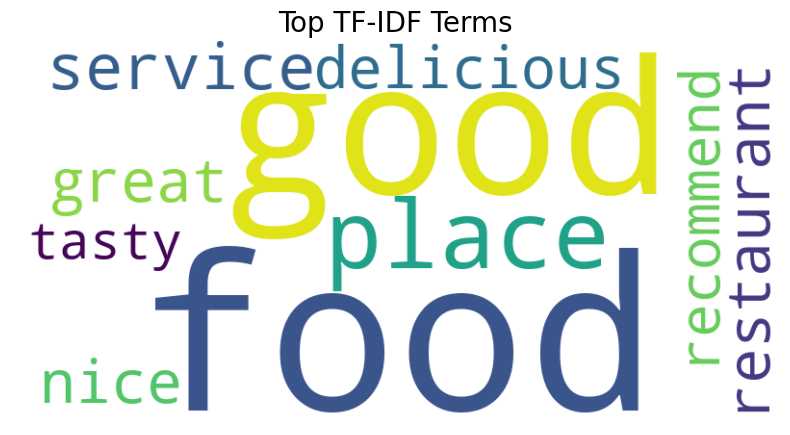

In [9]:
# Example: Generate word cloud with TF-IDF weights
from wordcloud import WordCloud

def plot_tfidf_wordcloud(tfidf_df, title):
    term_weights = {term: weight for term, weight in tfidf_df.items()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Create word cloud for top terms
plot_tfidf_wordcloud(top_terms, "Top TF-IDF Terms")

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Load dataset
df = pd.read_csv("../raw_data/clensed_reviews.csv")

# Preprocess text
def preprocess_text(text):
    # Remove punctuation, convert to lowercase
    return " ".join(word.lower() for word in str(text).split() if word.isalpha())

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Target category (example: 'food' sentiment)
category_col = 'service'
category_to_id = {cat: idx for idx, cat in enumerate(df[category_col].dropna().unique())}
df['category_id'] = df[category_col].map(category_to_id)

# Generate TF-IDF features
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
features = tfidf.fit_transform(df['cleaned_text'])
labels = df['category_id']

# Analyze top N correlated terms for each category
N = 5  # Number of terms to display
for category, category_id in category_to_id.items():
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])  # Sort features by chi-squared scores
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    # Extract unigrams, bigrams, and trigrams
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    
    print("# '{}' category:".format(category))
    print("  1. Most correlated unigrams:\n--> {}".format('\n--> '.join(unigrams[-N:])))
    print("  2. Most correlated bigrams:\n--> {}".format('\n--> '.join(bigrams[-N:])))
    print("  3. Most correlated trigrams:\n--> {}".format('\n--> '.join(trigrams[-N:])))


# 'Positive' category:
  1. Most correlated unigrams:
--> helpful
--> staff
--> nan
--> friendly
--> service
  2. Most correlated bigrams:
--> friendly service
--> good service
--> great service
--> nice service
--> friendly staff
  3. Most correlated trigrams:
--> definitely come back
--> would highly recommend
--> highly recommend restaurant
--> highly recommend place
--> food great service
# 'Negative' category:
  1. Most correlated unigrams:
--> hour
--> bad
--> waited
--> rude
--> minutes
  2. Most correlated bigrams:
--> ice cream
--> long time
--> highly recommend
--> much better
--> waiting time
  3. Most correlated trigrams:
--> would highly recommend
--> would definitely recommend
--> traditional polish food
--> definitely come back
--> highly recommend place
# 'Mixed' category:
  1. Most correlated unigrams:
--> poor
--> flavours
--> together
--> looked
--> chocolate
  2. Most correlated bigrams:
--> great food
--> good food
--> highly recommend
--> delicious food
--> good s